In [3]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import sqlite3
import json
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)

##  Set Up SQLite Optimizations

In [2]:
def optimize_sqlite_performance(conn):
    """Apply optimizations to SQLite connection for better performance"""
    c = conn.cursor()
    # Use WAL mode for better concurrency
    c.execute('PRAGMA journal_mode = WAL')
    # Reduce fsync calls
    c.execute('PRAGMA synchronous = NORMAL')
    # Increase cache size to 64MB
    c.execute('PRAGMA cache_size = -64000')
    # Store temp tables in memory
    c.execute('PRAGMA temp_store = MEMORY')
    # Larger mmap size
    c.execute('PRAGMA mmap_size = 30000000000')
    conn.commit()

## Create Database Schema

In [3]:
def create_database_schema(db_path):
    """Create the database schema for poker hand history analysis"""
    conn = sqlite3.connect(db_path)

    # Apply optimizations
    optimize_sqlite_performance(conn)
    
    c = conn.cursor()
    
    # Create tables
    c.execute('''
    CREATE TABLE IF NOT EXISTS games (
        game_id TEXT PRIMARY KEY,
        session_id TEXT,
        start_date TEXT,
        small_blind REAL,
        big_blind REAL,
        ante REAL,
        table_name TEXT,
        player_count INTEGER,
        is_tournament INTEGER
    )
    ''')
    
    c.execute('''
    CREATE TABLE IF NOT EXISTS players (
        player_id INTEGER PRIMARY KEY AUTOINCREMENT,
        player_name TEXT UNIQUE
    )
    ''')
    
    c.execute('''
    CREATE TABLE IF NOT EXISTS game_players (
        game_id TEXT,
        player_id INTEGER,
        position TEXT,
        position_numeric INTEGER,
        initial_stack REAL,
        is_hero INTEGER,
        is_dealer INTEGER,
        final_stack REAL,
        total_won REAL,
        total_bet REAL,
        PRIMARY KEY (game_id, player_id),
        FOREIGN KEY (game_id) REFERENCES games(game_id),
        FOREIGN KEY (player_id) REFERENCES players(player_id)
    )
    ''')
    
    c.execute('''
    CREATE TABLE IF NOT EXISTS cards (
        card_id INTEGER PRIMARY KEY AUTOINCREMENT,
        game_id TEXT,
        card_type TEXT,  -- Pocket, Flop, Turn, River
        player_id INTEGER NULL,
        card_values TEXT,
        FOREIGN KEY (game_id) REFERENCES games(game_id),
        FOREIGN KEY (player_id) REFERENCES players(player_id)
    )
    ''')
    
    c.execute('''
    CREATE TABLE IF NOT EXISTS actions (
        action_id INTEGER PRIMARY KEY AUTOINCREMENT,
        game_id TEXT,
        player_id INTEGER,
        action_round INTEGER,
        action_type INTEGER,
        simple_action_type TEXT,
        action_sum REAL,
        action_order INTEGER,
        pot_before_action REAL,
        players_remaining INTEGER,
        FOREIGN KEY (game_id) REFERENCES games(game_id),
        FOREIGN KEY (player_id) REFERENCES players(player_id)
    )
    ''')
    
    # Create useful indexes
    c.execute('CREATE INDEX IF NOT EXISTS idx_game_id ON actions(game_id)')
    c.execute('CREATE INDEX IF NOT EXISTS idx_player_id ON actions(player_id)')
    c.execute('CREATE INDEX IF NOT EXISTS idx_action_type ON actions(simple_action_type)')
    c.execute('CREATE INDEX IF NOT EXISTS idx_game_players ON game_players(game_id, player_id)')
    
    conn.commit()
    conn.close()
    
    # Create the directory for the WAL files if it doesn't exist
    wal_dir = os.path.dirname(db_path)
    os.makedirs(wal_dir, exist_ok=True)
    
    print(f"Database schema created at {db_path}")

## Data Extraction Functions

In [4]:
def safe_float(text):
    """Convert text to float, handling currency symbols and errors"""
    try:
        return float(re.sub(r"[^\d\.]", "", text))
    except Exception:
        return 0.0

def street_from_round(round_no):
    """Convert round number to street name"""
    return {0: "blinds", 1: "preflop", 2: "flop", 3: "turn", 4: "river"}.get(round_no, "unknown")

def get_action_type(type_code):
    """Convert action type code to readable format"""
    action_types = {
        0: "fold", 
        1: "small_blind", 
        2: "big_blind", 
        3: "call", 
        4: "check", 
        5: "raise", 
        7: "raise", 
        15: "ante",
        23: "raise"
    }
    return action_types.get(type_code, f"unknown_{type_code}")

def simplify_action(action_details, round_no, blinds, pot_before_action, round_contributions, current_round_max):
    """
    Simplify the action into a single string category based on context.
    """
    allowed_types = {0: "fold", 3: "call", 4: "check", 5: "raise", 7: "raise", 15: "ante", 23: "raise"}
    orig_type = action_details['action_type']
    if orig_type not in allowed_types:
        return None
    base_action = allowed_types[orig_type]
    new_action = action_details.copy()
    
    if base_action != "raise":
        new_action["simple_action_type"] = base_action
    else:
        if round_no == 1:  # Preflop
            bb = blinds.get("big_blind", 1)
            ratio = action_details['action_sum'] / bb if bb != 0 else 0
            if ratio <= 2.2:
                new_action["simple_action_type"] = "small_raise_preflop"
            elif ratio <= 2.7:
                new_action["simple_action_type"] = "mid_raise_preflop"
            elif ratio <= 3.2:
                new_action["simple_action_type"] = "big_raise_preflop"
            else:
                new_action["simple_action_type"] = "all_in_preflop"
        else:  # Postflop
            current_player_contrib = round_contributions.get(action_details['player_id'], 0)
            call_amount = max(0, current_round_max - current_player_contrib)
            effective_raise = action_details['action_sum'] - call_amount
            effective_pot = pot_before_action + call_amount
            ratio = effective_raise / effective_pot if effective_pot > 0 else 0
            if ratio <= 0.33:
                new_action["simple_action_type"] = "small_raise_postflop"
            elif ratio <= 0.66:
                new_action["simple_action_type"] = "mid_raise_postflop"
            else:
                new_action["simple_action_type"] = "big_raise_postflop"
    return new_action

## XML Parsing and Database Population

In [5]:
def get_or_create_player_id(conn, player_name):
    """Get or create a player ID for a given player name"""
    c = conn.cursor()
    c.execute("SELECT player_id FROM players WHERE player_name = ?", (player_name,))
    result = c.fetchone()
    if result:
        return result[0]
    else:
        c.execute("INSERT INTO players (player_name) VALUES (?)", (player_name,))
        conn.commit()
        return c.lastrowid

def parse_and_store_hand_history(xml_file_path, db_path):
    """Parse an XML hand history file and store it in the database"""
    try:
        conn = sqlite3.connect(db_path)
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        
        # Get session info
        session_id = root.attrib.get('sessioncode', '')
        session_general = root.find('general')
        hero_nickname = session_general.findtext('nickname', '')
        
        # Process each game
        for game in root.findall('game'):
            game_id = game.attrib.get('gamecode', '')
            
            # Check if this game is already in the database
            c = conn.cursor()
            c.execute("SELECT 1 FROM games WHERE game_id = ?", (game_id,))
            if c.fetchone():
                continue  # Skip if already processed
            
            # Parse general game info
            general = game.find('general')
            
            # Get blinds and ante
            small_blind = safe_float(general.findtext('smallblind', "0"))
            big_blind = safe_float(general.findtext('bigblind', "0"))
            ante = safe_float(general.findtext('ante', "0"))
            
            # Get start date
            start_date = general.findtext('startdate', '')
            
            # Get table info
            table_name = ''
            is_tournament = 0
            for parent_general in root.findall('general'):
                table_name = parent_general.findtext('tablename', '')
                is_tournament = 1 if parent_general.findtext('tournamentcode', '') else 0
            
            # Get player count
            players_elem = general.find('players')
            player_count = len(players_elem.findall('player')) if players_elem is not None else 0
            
            # Store game info
            c.execute('''
                INSERT INTO games 
                (game_id, session_id, start_date, small_blind, big_blind, ante, table_name, player_count, is_tournament)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (game_id, session_id, start_date, small_blind, big_blind, ante, table_name, player_count, is_tournament))
            
            # Get player positions
            player_positions = {}
            position_numeric = {}
            
            # Find button player
            button_player = None
            for p in players_elem.findall('player'):
                if p.attrib.get('dealer', '0') == '1':
                    button_player = p.attrib.get('name')
                    break
            
            # Find SB and BB from round 0 actions
            sb_player = None
            bb_player = None
            for r in game.findall('round'):
                if r.attrib.get('no') == '0':
                    for act in r.findall('action'):
                        action_type = act.attrib.get('type')
                        player = act.attrib.get('player')
                        if action_type == '1':
                            sb_player = player
                        elif action_type == '2':
                            bb_player = player
            
            # Assign positions
            heads_up = (player_count == 2)
            
            # For 2-player games
            if heads_up and button_player and sb_player:
                player_positions[button_player] = 'BTN/SB'
                position_numeric[button_player] = 0
                
                # In heads-up, the other player must be BB
                for p in players_elem.findall('player'):
                    player_name = p.attrib.get('name')
                    if player_name != button_player:
                        player_positions[player_name] = 'BB'
                        position_numeric[player_name] = 1
                        break
            # For 3+ player games
            else:
                if sb_player:
                    player_positions[sb_player] = 'SB'
                    position_numeric[sb_player] = 0
                if bb_player:
                    player_positions[bb_player] = 'BB'
                    position_numeric[bb_player] = 1
                
                # In 3-player games, the third position is button if not SB or BB
                if player_count == 3 and button_player:
                    if button_player not in (sb_player, bb_player):
                        player_positions[button_player] = 'BTN'
                        position_numeric[button_player] = 2
                
                # For games with more players, we would need more logic here
                # This is a simplification for common 2-3 player games
            
            # Process each player
            for p in players_elem.findall('player'):
                player_name = p.attrib.get('name')
                player_id = get_or_create_player_id(conn, player_name)
                initial_stack = safe_float(p.attrib.get('chips', '0'))
                is_hero = 1 if player_name == hero_nickname else 0
                is_dealer = 1 if p.attrib.get('dealer', '0') == '1' else 0
                final_stack = initial_stack  # Will update later with bets/wins
                total_won = safe_float(p.attrib.get('win', '0'))
                total_bet = safe_float(p.attrib.get('bet', '0'))
                
                position = player_positions.get(player_name, 'unknown')
                pos_num = position_numeric.get(player_name, -1)
                
                # Store player info for this game
                c.execute('''
                    INSERT INTO game_players
                    (game_id, player_id, position, position_numeric, initial_stack, is_hero, is_dealer, final_stack, total_won, total_bet)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                ''', (game_id, player_id, position, pos_num, initial_stack, is_hero, is_dealer, final_stack, total_won, total_bet))
            
            # Process cards
            for r in game.findall('round'):
                for card in r.findall('cards'):
                    card_type = card.attrib.get('type')
                    player_name = card.attrib.get('player', None)
                    card_values = card.text.strip() if card.text else ''
                    
                    if player_name:
                        player_id = get_or_create_player_id(conn, player_name)
                    else:
                        player_id = None
                    
                    # Store card info
                    c.execute('''
                        INSERT INTO cards
                        (game_id, card_type, player_id, card_values)
                        VALUES (?, ?, ?, ?)
                    ''', (game_id, card_type, player_id, card_values))
            
            # Process actions with contextualized information
            active_players = {get_or_create_player_id(conn, p.attrib.get('name')): True for p in players_elem.findall('player')}
            pot_size = 0.0
            action_order = 0
            
            # Track cumulative contributions
            player_contributions = {get_or_create_player_id(conn, p.attrib.get('name')): 0.0 for p in players_elem.findall('player')}
            
            for r in game.findall('round'):
                round_no = int(r.attrib.get('no', '0'))
                
                # Reset round contributions and maximum for new betting rounds
                if round_no >= 1:
                    round_contributions = {player_id: 0.0 for player_id in player_contributions}
                    current_round_max = 0.0
                
                for action in r.findall('action'):
                    player_name = action.attrib.get('player')
                    player_id = get_or_create_player_id(conn, player_name)
                    action_type = int(action.attrib.get('type', '0'))
                    action_sum = safe_float(action.attrib.get('sum', '0'))
                    action_order += 1
                    
                    # Prepare action details
                    action_details = {
                        'player_id': player_id,
                        'action_type': action_type,
                        'action_sum': action_sum,
                        'action_round': round_no
                    }
                    
                    # Skip round 0 for simplification analysis (just
                    # For rounds ≥ 1, analyze actions in context
                    if round_no >= 1:
                        current_pot = pot_size
                        players_remaining = sum(1 for v in active_players.values() if v)
                        
                        # Simplify the action using the round-level data
                        simple_action = simplify_action(
                            action_details, 
                            round_no, 
                            {"big_blind": big_blind, "small_blind": small_blind, "ante": ante}, 
                            current_pot, 
                            round_contributions, 
                            current_round_max
                        )
                        
                        if simple_action is not None:
                            # Store the action with context
                            c.execute('''
                                INSERT INTO actions
                                (game_id, player_id, action_round, action_type, simple_action_type, 
                                action_sum, action_order, pot_before_action, players_remaining)
                                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
                            ''', (
                                game_id, 
                                player_id, 
                                round_no, 
                                action_type, 
                                simple_action.get("simple_action_type", get_action_type(action_type)), 
                                action_sum, 
                                action_order, 
                                current_pot, 
                                players_remaining
                            ))
                        
                        # Update round-level contributions for this action
                        round_contributions[player_id] = round_contributions.get(player_id, 0) + action_sum
                        current_round_max = max(current_round_max, round_contributions[player_id])
                    else:
                        # For round 0 (blinds/antes), just record the action
                        c.execute('''
                            INSERT INTO actions
                            (game_id, player_id, action_round, action_type, simple_action_type, 
                            action_sum, action_order, pot_before_action, players_remaining)
                            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
                        ''', (
                            game_id, 
                            player_id, 
                            round_no, 
                            action_type, 
                            get_action_type(action_type), 
                            action_sum, 
                            action_order, 
                            pot_size, 
                            player_count
                        ))
                    
                    # Update cumulative contributions and pot
                    if player_id in player_contributions:
                        player_contributions[player_id] += action_sum
                    pot_size += action_sum
                    
                    # Mark a player as inactive if they folded
                    if action_type == 0:  # fold
                        active_players[player_id] = False
            
            # Update final stacks for each player
            for player_id, contribution in player_contributions.items():
                c.execute('''
                    UPDATE game_players
                    SET final_stack = (
                        SELECT initial_stack + total_won - total_bet 
                        FROM game_players
                        WHERE game_id = ? AND player_id = ?
                    )
                    WHERE game_id = ? AND player_id = ?
                ''', (game_id, player_id, game_id, player_id))
            
            conn.commit()
        
        conn.close()
        return True
    except Exception as e:
        print(f"Error processing file {xml_file_path}: {e}")
        if 'conn' in locals() and conn:
            conn.close()
        return False

def process_directory(directory_path, db_path, limit=None):
    """Process all XML files in a directory and store them in the database"""
    # Create database schema if it doesn't exist
    if not os.path.exists(db_path):
        create_database_schema(db_path)
    
    # Get all XML files
    xml_files = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".xml"):
                xml_files.append(os.path.join(root, file))
    
    # Limit files if requested
    if limit and limit > 0:
        if limit < len(xml_files):
            xml_files = xml_files[:limit]
    
    # Process each file
    total_files = len(xml_files)
    processed_files = 0
    success_count = 0
    
    print(f"Processing {total_files} XML files...")
    
    for file_path in tqdm(xml_files, desc="Processing XML files"):
        if parse_and_store_hand_history(file_path, db_path):
            success_count += 1
        processed_files += 1
        
        # Periodic status update
        if processed_files % 100 == 0:
            print(f"Processed {processed_files}/{total_files} files ({success_count} successful)")
    
    print(f"Finished processing {processed_files} files. {success_count} were successfully imported.")




## Query Functions for Analysis

In [6]:
def get_position_frequencies(db_path, position):
    """Get action frequencies for a specific position"""
    conn = sqlite3.connect(db_path)
    
    query = """
    SELECT a.simple_action_type, COUNT(*) as count
    FROM actions a
    JOIN game_players gp ON a.game_id = gp.game_id AND a.player_id = gp.player_id
    WHERE gp.position = ? AND a.action_round = 1  -- Preflop actions only
    GROUP BY a.simple_action_type
    ORDER BY count DESC
    """
    
    df = pd.read_sql_query(query, conn, params=(position,))
    conn.close()
    
    # Calculate frequencies
    total = df['count'].sum()
    if total > 0:
        df['frequency'] = df['count'] / total
    
    return df

def get_reaction_frequencies(db_path, facing_action, position):
    """Get reaction frequencies when facing a specific action in a position"""
    conn = sqlite3.connect(db_path)
    
    # This is a more complex query as we need to find sequences of actions
    query = """
    WITH previous_actions AS (
        SELECT 
            a1.game_id,
            a1.action_order,
            a1.simple_action_type as prev_action,
            gp1.position as prev_position,
            a1.player_id as prev_player_id
        FROM actions a1
        JOIN game_players gp1 ON a1.game_id = gp1.game_id AND a1.player_id = gp1.player_id
        WHERE a1.action_round = 1  -- Preflop actions only
    ),
    responses AS (
        SELECT 
            a2.game_id,
            a2.simple_action_type as response,
            gp2.position as response_position,
            pa.prev_action,
            pa.prev_position
        FROM actions a2
        JOIN game_players gp2 ON a2.game_id = gp2.game_id AND a2.player_id = gp2.player_id
        JOIN previous_actions pa ON a2.game_id = pa.game_id AND a2.action_order = pa.action_order + 1
        WHERE a2.action_round = 1  -- Preflop actions only
        AND gp2.position = ?  -- Responding position filter
        AND pa.prev_action = ?  -- Facing action filter
    )
    
    SELECT response, COUNT(*) as count
    FROM responses
    GROUP BY response
    ORDER BY count DESC
    """
    
    df = pd.read_sql_query(query, conn, params=(position, facing_action))
    conn.close()
    
    # Calculate frequencies
    total = df['count'].sum()
    if total > 0:
        df['frequency'] = df['count'] / total
    
    return df

def get_street_frequencies(db_path, street):
    """Get action frequencies for a specific street"""
    conn = sqlite3.connect(db_path)
    
    round_map = {"preflop": 1, "flop": 2, "turn": 3, "river": 4}
    round_no = round_map.get(street, 1)
    
    query = """
    SELECT gp.position, a.simple_action_type, COUNT(*) as count
    FROM actions a
    JOIN game_players gp ON a.game_id = gp.game_id AND a.player_id = gp.player_id
    WHERE a.action_round = ?
    GROUP BY gp.position, a.simple_action_type
    ORDER BY gp.position, count DESC
    """
    
    df = pd.read_sql_query(query, conn, params=(round_no,))
    conn.close()
    
    # Calculate frequencies by position
    result = []
    for position in df['position'].unique():
        position_df = df[df['position'] == position].copy()
        total = position_df['count'].sum()
        if total > 0:
            position_df['frequency'] = position_df['count'] / total
        result.append(position_df)
    
    return pd.concat(result)

def get_stats_by_player(db_path, limit=100):
    """Get basic stats for each player"""
    conn = sqlite3.connect(db_path)
    
    query = """
    SELECT 
        p.player_name,
        COUNT(DISTINCT gp.game_id) as hands_played,
        SUM(CASE WHEN gp.final_stack > gp.initial_stack THEN 1 ELSE 0 END) as hands_won,
        SUM(gp.total_bet) as total_bet,
        SUM(gp.total_won) as total_won,
        SUM(gp.total_won - gp.total_bet) as profit,
        AVG(CASE WHEN a.action_round = 1 AND a.simple_action_type LIKE '%raise%' THEN 1 ELSE 0 END) as pfr,
        AVG(CASE WHEN a.action_round = 1 AND (a.simple_action_type = 'call' OR a.simple_action_type LIKE '%raise%') THEN 1 ELSE 0 END) as vpip
    FROM players p
    JOIN game_players gp ON p.player_id = gp.player_id
    LEFT JOIN actions a ON gp.game_id = a.game_id AND gp.player_id = a.player_id
    GROUP BY p.player_name
    ORDER BY hands_played DESC
    LIMIT ?
    """
    
    df = pd.read_sql_query(query, conn, params=(limit,))
    conn.close()
    
    # Calculate derived metrics
    df['win_rate'] = df['hands_won'] / df['hands_played']
    
    return df

## Visualization Functions

In [7]:
def plot_position_frequencies(db_path, positions=None):
    """Plot action frequencies by position"""
    if positions is None:
        positions = ['BTN', 'SB', 'BB']
    
    fig, axes = plt.subplots(len(positions), 1, figsize=(10, 4*len(positions)))
    if len(positions) == 1:
        axes = [axes]
    
    for i, position in enumerate(positions):
        df = get_position_frequencies(db_path, position)
        
        if not df.empty:
            ax = axes[i]
            sns.barplot(x='simple_action_type', y='frequency', data=df, ax=ax)
            ax.set_title(f'Action Frequencies for {position}')
            ax.set_xlabel('Action Type')
            ax.set_ylabel('Frequency')
            ax.set_ylim(0, 1)
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2%}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha = 'center', va = 'bottom')
    
    plt.tight_layout()
    return fig

def plot_player_stats(db_path, metric='vpip', top_n=20):
    """Plot player stats for a specific metric"""
    df = get_stats_by_player(db_path, limit=top_n)
    
    if not df.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='player_name', y=metric, data=df)
        plt.title(f'Top {top_n} Players by {metric}')
        plt.xlabel('Player')
        plt.ylabel(metric.upper())
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        return plt.gcf()
    
def create_frequency_lookup_table(db_path, output_path):
    """Create a JSON lookup table of frequencies for different scenarios"""
    conn = sqlite3.connect(db_path)
    
    # Dictionary to store all frequencies
    frequency_table = {
        "positions": {},
        "streets": {},
        "reactions": {}
    }
    
    # Get position frequencies
    positions = ['BTN', 'SB', 'BB']
    for position in positions:
        query = """
        SELECT a.simple_action_type, COUNT(*) as count
        FROM actions a
        JOIN game_players gp ON a.game_id = gp.game_id AND a.player_id = gp.player_id
        WHERE gp.position = ? AND a.action_round = 1
        GROUP BY a.simple_action_type
        """
        
        df = pd.read_sql_query(query, conn, params=(position,))
        total = df['count'].sum()
        if total > 0:
            frequency_table["positions"][position] = {
                row['simple_action_type']: row['count'] / total 
                for _, row in df.iterrows()
            }
    
    # Get street frequencies
    streets = {1: "preflop", 2: "flop", 3: "turn", 4: "river"}
    for round_no, street in streets.items():
        query = """
        SELECT gp.position, a.simple_action_type, COUNT(*) as count
        FROM actions a
        JOIN game_players gp ON a.game_id = gp.game_id AND a.player_id = gp.player_id
        WHERE a.action_round = ?
        GROUP BY gp.position, a.simple_action_type
        """
        
        df = pd.read_sql_query(query, conn, params=(round_no,))
        
        frequency_table["streets"][street] = {}
        for position in df['position'].unique():
            position_df = df[df['position'] == position]
            total = position_df['count'].sum()
            if total > 0:
                frequency_table["streets"][street][position] = {
                    row['simple_action_type']: row['count'] / total 
                    for _, row in position_df.iterrows()
                }
    
    # Get reaction frequencies (e.g., facing a raise)
    key_actions = ['small_raise_preflop', 'call', 'raise_preflop']
    for action in key_actions:
        frequency_table["reactions"][action] = {}
        
        for position in positions:
            query = """
            WITH previous_actions AS (
                SELECT 
                    a1.game_id,
                    a1.action_order,
                    a1.simple_action_type as prev_action,
                    a1.player_id as prev_player_id
                FROM actions a1
                WHERE a1.action_round = 1 AND a1.simple_action_type = ?
            ),
            responses AS (
                SELECT 
                    a2.game_id,
                    a2.simple_action_type as response,
                    gp2.position as response_position,
                    pa.prev_action
                FROM actions a2
                JOIN game_players gp2 ON a2.game_id = gp2.game_id AND a2.player_id = gp2.player_id
                JOIN previous_actions pa ON a2.game_id = pa.game_id AND a2.action_order = pa.action_order + 1
                WHERE a2.action_round = 1 AND gp2.position = ?
            )
            
            SELECT response, COUNT(*) as count
            FROM responses
            GROUP BY response
            """
            
            df = pd.read_sql_query(query, conn, params=(action, position))
            total = df['count'].sum()
            if total > 0:
                frequency_table["reactions"][action][position] = {
                    row['response']: row['count'] / total 
                    for _, row in df.iterrows()
                }
    
    conn.close()
    
    # Save to JSON file
    with open(output_path, 'w') as f:
        json.dump(frequency_table, f, indent=2)
    
    print(f"Frequency lookup table created and saved to {output_path}")

In [ ]:
def main():
    """Main function to demonstrate the workflow"""
    # Configuration
    db_path = "poker_analysis.db"
    xml_folder = "ipoker_hh_test"  # Folder containing XML files
    frequency_table_path = "frequency_lookup_table.json"
    
    # Process a limited number of files for demonstration
    process_directory(xml_folder, db_path, limit=100)  # Adjust limit as needed
    
    # Create frequency lookup table
    create_frequency_lookup_table(db_path, frequency_table_path)
    
    # Generate and display visualizations
    fig1 = plot_position_frequencies(db_path)
    fig2 = plot_player_stats(db_path, metric='vpip')
    
    # Query example: get position frequencies for BTN
    btn_freqs = get_position_frequencies(db_path, 'BTN')
    print("BTN Position Frequencies:")
    print(btn_freqs)
    
    # Query example: get reaction frequencies when facing a raise
    reaction_freqs = get_reaction_frequencies(db_path, 'small_raise_preflop', 'BB')
    print("\nBB Reaction Frequencies when facing a small raise:")
    print(reaction_freqs)
    
    # Query example: get street frequencies
    flop_freqs = get_street_frequencies(db_path, 'flop')
    print("\nFlop Action Frequencies by Position:")
    print(flop_freqs)
    
    # Show the generated visualizations
    plt.show()

if __name__ == "__main__":
    main()

Processing 100 XML files...


Processing XML files: 100%|██████████| 100/100 [00:00<00:00, 699.90it/s]

Processed 100/100 files (100 successful)
Finished processing 100 files. 100 were successfully imported.


Frequency lookup table created and saved to frequency_lookup_table.json


In [8]:
def get_sb_action_after_btn_fold(db_path, min_bb=15, max_bb=20):
    """Get SB action frequencies when BTN folds with stack size between min_bb and max_bb"""
    conn = sqlite3.connect(db_path)
    
    query = """
    WITH btn_folds AS (
        SELECT 
            a1.game_id,
            a1.action_order,
            gp_btn.initial_stack / g.big_blind as btn_stack_bb
        FROM actions a1
        JOIN game_players gp_btn ON a1.game_id = gp_btn.game_id AND a1.player_id = gp_btn.player_id
        JOIN games g ON a1.game_id = g.game_id
        WHERE gp_btn.position = 'BTN' 
        AND a1.simple_action_type = 'fold'
        AND a1.action_round = 1
        AND gp_btn.initial_stack / g.big_blind BETWEEN ? AND ?
    ),
    sb_actions AS (
        SELECT 
            a2.game_id,
            a2.simple_action_type,
            bf.btn_stack_bb
        FROM actions a2
        JOIN game_players gp_sb ON a2.game_id = gp_sb.game_id AND a2.player_id = gp_sb.player_id
        JOIN btn_folds bf ON a2.game_id = bf.game_id AND a2.action_order = bf.action_order + 1
        WHERE gp_sb.position = 'SB'
        AND a2.action_round = 1
    )
    
    SELECT simple_action_type, COUNT(*) as count
    FROM sb_actions
    GROUP BY simple_action_type
    ORDER BY count DESC
    """
    
    df = pd.read_sql_query(query, conn, params=(min_bb, max_bb))
    conn.close()
    
    # Calculate frequencies
    total = df['count'].sum()
    if total > 0:
        df['frequency'] = df['count'] / total
    
    return df

SB actions when BTN folds (15-20bb):
    simple_action_type  count  frequency
0                 call  25695   0.380413
1       all_in_preflop  15678   0.232112
2  small_raise_preflop  13752   0.203598
3                 fold  11160   0.165223
4    big_raise_preflop    855   0.012658
5    mid_raise_preflop    405   0.005996


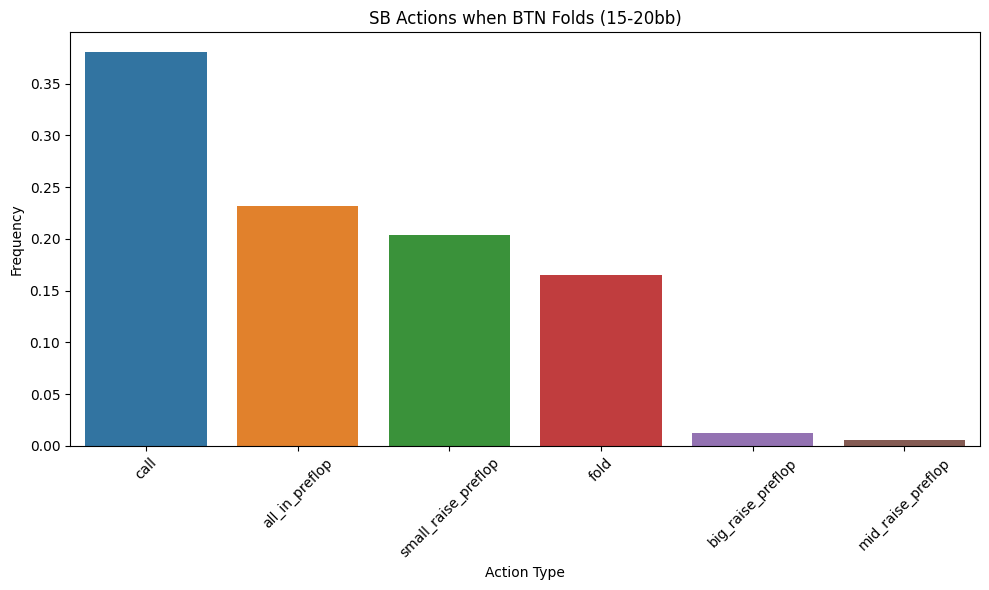

In [9]:
sb_actions = get_sb_action_after_btn_fold("poker_analysis_optimized.db", 15, 20)
print("SB actions when BTN folds (15-20bb):")
print(sb_actions)

# To visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='simple_action_type', y='frequency', data=sb_actions)
plt.title('SB Actions when BTN Folds (15-20bb)')
plt.xlabel('Action Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()